Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Exists root? True
Contents root: ['imdb.vocab', 'imdbEr.txt', 'README', 'train', 'test']
Train: 25000 Test: 25000
Loaded w2v: 300 dims
MAX  2514
Training RNN-MAX-POOLING...
Epoch 1/10 | Train Loss: 0.4146 | Dev Loss: 0.3181
Epoch 2/10 | Train Loss: 0.2858 | Dev Loss: 0.2747
Epoch 3/10 | Train Loss: 0.2589 | Dev Loss: 0.3084
Epoch 4/10 | Train Loss: 0.2220 | Dev Loss: 0.2612
Epoch 5/10 | Train Loss: 0.1978 | Dev Loss: 0.3028
Epoch 6/10 | Train Loss: 0.1799 | Dev Loss: 0.2628
Epoch 7/10 | Train Loss: 0.1430 | Dev Loss: 0.2632
Epoch 8/10 | Train Loss: 0.1177 | Dev Loss: 0.3139
Epoch 9/10 | Train Loss: 0.0913 | Dev Loss: 0.2988
Epoch 10/10 | Train Loss: 0.0758 | Dev Loss: 0.3398
Training GRU-MAX-POOLING...
Epoch 1/10 | Train Loss: 0.4042 | Dev Loss: 0.3042
Epoch 2/10 | Train Loss: 0.2974 | Dev Loss: 0.2776
Epoch 3/10 | Train Loss: 0.2631 | Dev Loss: 0.2538
Epoch 

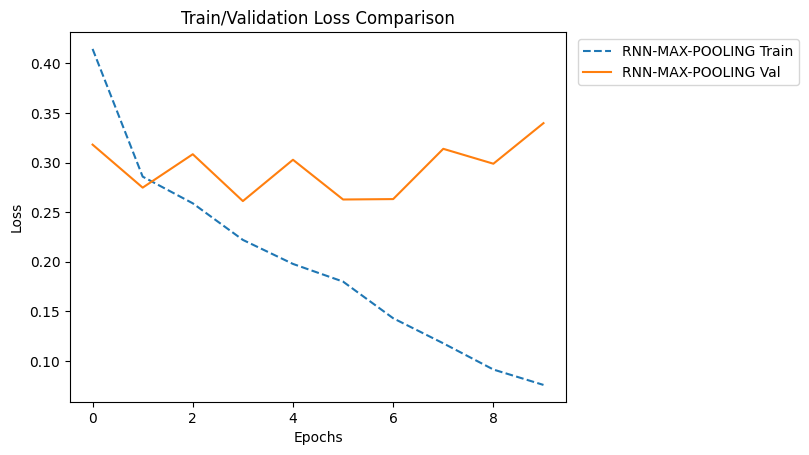

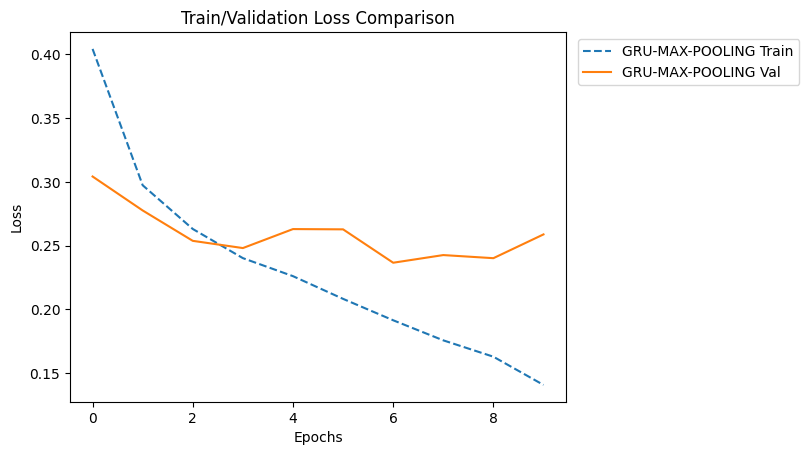

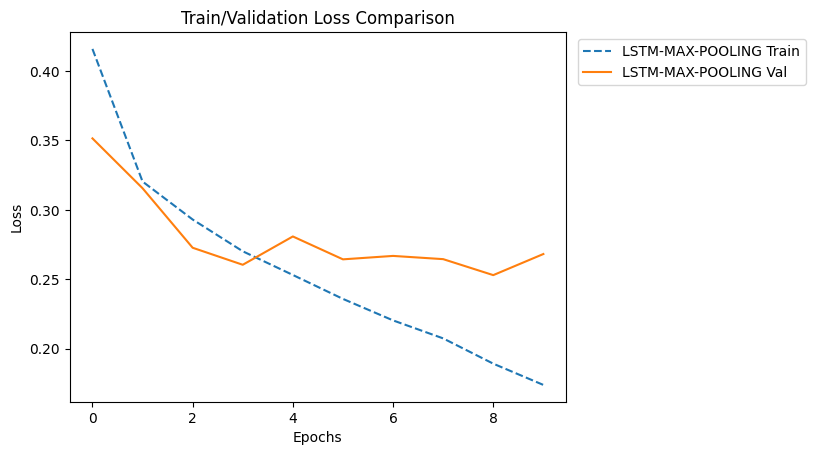

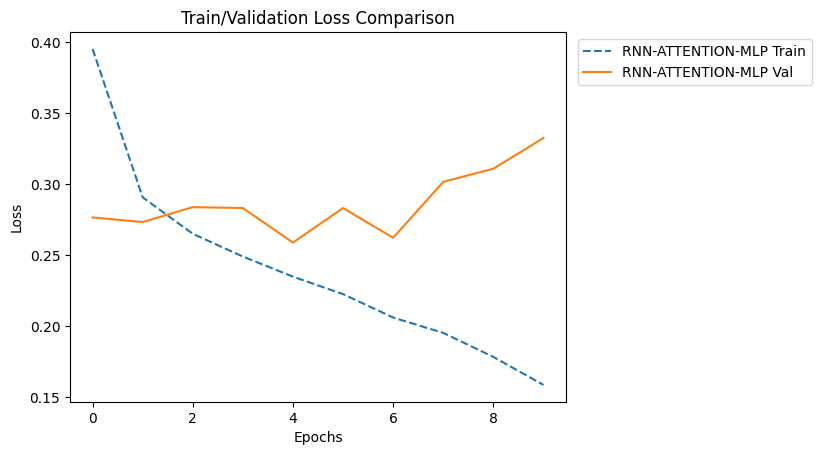

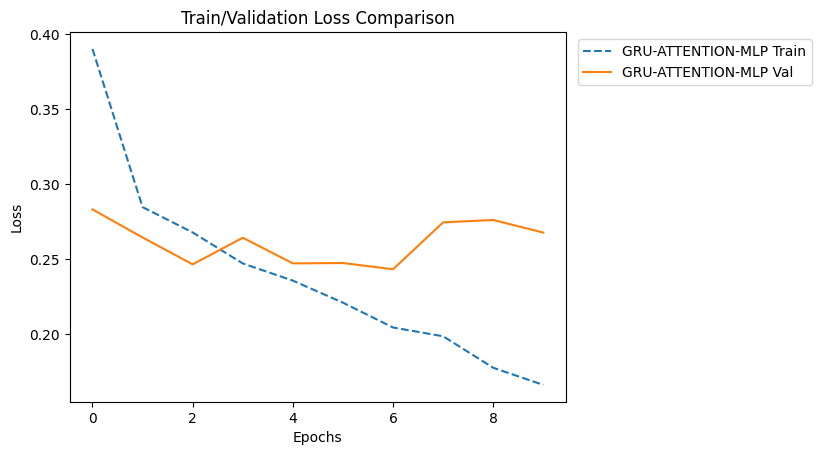

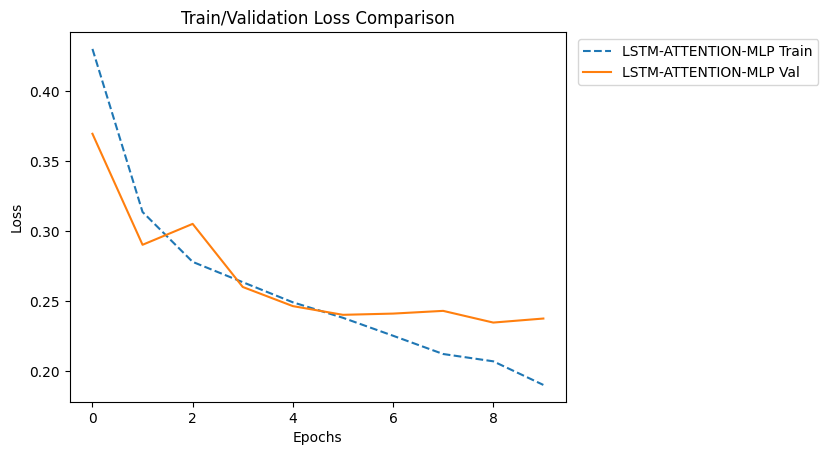

MODEL: RNN-MAX-POOLING
Accuracy: 0.8850

Per-class results (test set):
              precision    recall  f1-score   support

           0     0.9038    0.8618    0.8823     12500
           1     0.8679    0.9082    0.8876     12500

    accuracy                         0.8850     25000
   macro avg     0.8858    0.8850    0.8849     25000
weighted avg     0.8858    0.8850    0.8849     25000


Micro avg:
 Precision: 0.8850
 Recall:    0.8850
 F1:        0.8850
MODEL: GRU-MAX-POOLING
Accuracy: 0.8981

Per-class results (test set):
              precision    recall  f1-score   support

           0     0.9134    0.8797    0.8962     12500
           1     0.8840    0.9166    0.9000     12500

    accuracy                         0.8981     25000
   macro avg     0.8987    0.8981    0.8981     25000
weighted avg     0.8987    0.8981    0.8981     25000


Micro avg:
 Precision: 0.8981
 Recall:    0.8981
 F1:        0.8981
MODEL: LSTM-MAX-POOLING
Accuracy: 0.8895

Per-class results (test 

In [3]:
!pip install -q gensim
!pip install scikit-learn

import os, glob, re
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score, precision_recall_fscore_support
from gensim.models import KeyedVectors

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length):
        self.vocab = vocab
        self.max_length = max_length
        self.texts = [self.tokenize(t) for t in texts]
        self.labels = labels

    def tokenize(self, text):
        words = re.sub(r'[^a-zA-Z]', ' ', text.lower()).split()
        ids = [self.vocab.get(w, self.vocab['UNK']) for w in words]
        ids = ids[:self.max_length]
        pad_len = self.max_length - len(ids)
        ids = ids + [self.vocab['PAD']] * pad_len
        return ids

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        ids = torch.tensor(self.texts[idx], dtype=torch.long)          # (T,)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return ids, label




class MLP(nn.Module):
    def __init__(self, hidden_dim, attn_hidden_dim=128):
        super().__init__()

        self.attn = nn.Sequential(nn.Linear(hidden_dim, attn_hidden_dim), nn.Tanh(), nn.Linear(attn_hidden_dim, 1))

    def forward(self, rnn_outputs, mask):
        # rnn_outputs: (batch_size X T X D=2H)
        # mask: (batch_size X T) with 1 for real tokens, 0 for PAD

        scores = self.attn(rnn_outputs).squeeze(-1)  # (batch_size X T)
        scores = scores.masked_fill(mask == 0, -1e9) #αγνοηση των PAD
        weights = torch.softmax(scores, dim=1)       # (batch_size X T)

        context = torch.sum(rnn_outputs * weights.unsqueeze(-1), dim=1)  # (batch_size X D=2H)

        return weights, context



class RNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, embedding_matrix,
                 hidden_size, num_layers, num_classes,
                 use_pooling, use_attention, model_type,
                 attn_hidden_dim=128, pad_id=0, freeze=True):
        super(RNN, self).__init__()

        self.pad_id = pad_id
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.use_pooling = use_pooling
        self.use_attention = use_attention
        self.model_type = model_type
        D = self.hidden_size *2 #(BIDERECTIONAL DIMENION FOR EVERY HIDDEN STATE)

        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=freeze, padding_idx=pad_id
        )


        if self.model_type == 'GRU':
            self.gru = nn.GRU(emb_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        elif self.model_type == 'LSTM':
            self.lstm = nn.LSTM(emb_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        else:
            self.rnn = nn.RNN(emb_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)

        if self.use_attention == True:
            self.attention = MLP(D, attn_hidden_dim=128)
        else:
            self.attention = None

        self.fc = nn.Linear(D, num_classes)


    def forward(self, ids):
        batch_size = ids.size(0)
        device = ids.device
        #ολοι οι tensor στην μνημη της ιδιας συσκευης
        #ids = batch_size X T
        mask = (ids != self.pad_id).long()   # (batch_size X T)
        emb = self.embedding(ids)

        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size, device=device)
        #emb_batch ε R^(μεγεθος batch(πχ batch_size=16) Χ αριθμος λεξεων σε καθε κριτικη(T) Χ μεγεθος 1 λεξης embedding( 300 = word2vec)

        if self.model_type == 'GRU':
            out, _ = self.gru(emb, h0)
        elif self.model_type == 'LSTM':
            c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size,device=device)
            out, _ = self.lstm(emb, (h0, c0))
            #τελευταίο hidden state απο καθε layer, αχρηστο
        else:
            out, _ = self.rnn(emb,h0)

        if self.use_pooling:
            #max pooling, αλλά θέλουμε να αγνοήσουμε PAD
            out_masked = out.masked_fill(mask.unsqueeze(-1) == 0, -1e9)
            pooled = torch.max(out_masked, dim=1).values     # (batch_size X D)
            logits = self.fc(pooled)                         # (batch_size X Categories = 2)
            return logits


        elif self.use_attention:          #context vector c = Σah
            attention_weights, context_vec = self.attention(out, mask)
            logits = self.fc(context_vec)
            return logits

        return out

  #----------------------------------------------------------------------------------------------------------------


def load_aclImdb_split(split_dir, maxes):
    texts, labels = [], []
    for label_name, y in [("neg", 0), ("pos", 1)]:
        pattern = os.path.join(split_dir, label_name, "*.txt")
        for fp in glob.glob(pattern):
            with open(fp, "r", encoding="utf-8") as f:
                text = f.read()
                texts.append(text)
                labels.append(y)
                words = re.sub(r'[^a-zA-Z]', ' ', text.lower()).split()
                maxes.append(len(words))
    return texts, labels, maxes


def build_vocab(texts, min_freq=2):
    counter = Counter()
    for t in texts:
        words = re.sub(r'[^a-zA-Z]', ' ', t.lower()).split()
        counter.update(words)

    vocab = {"PAD": 0, "UNK": 1}
    for w, c in counter.items():
        if c >= min_freq:
            vocab[w] = len(vocab)
    return vocab



  #-----------------------------------------------------------------------------------------------------------------

def build_embedding_matrix(vocab, w2v, emb_dim=300):
    V = len(vocab)
    pad_id = vocab["PAD"]
    unk_id = vocab["UNK"]

    #mean vector για UNK
    mean_vec = np.mean(w2v.vectors, axis=0)  # (300,)

    M = np.zeros((V, emb_dim), dtype=np.float32)

    for word, idx in vocab.items():
        if idx == pad_id:
            M[idx] = np.zeros(emb_dim)                 #PAD -> 0
        elif word in w2v:
            M[idx] = w2v[word]                         #γνωστή λέξη
        else:
            M[idx] = mean_vec                          #UNK -> mean

    M[unk_id] = mean_vec  #σιγουριά για UNK

    return torch.tensor(M, dtype=torch.float)   #vocanulary X 300

#--------------------------------------------------------------------------------------------------------------------

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    best_state = None

    for epoch in range(epochs):
        # -------- TRAIN --------
        model.train()
        total_train_loss = 0

        for ids, labels in train_loader:
            ids = ids.to(device)
            labels = labels.to(device)              # (B,) long

            optimizer.zero_grad()
            logits = model(ids)                     # (B, 2)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # -------- VALIDATION --------
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for ids, labels in val_loader:
                ids = ids.to(device)
                labels = labels.to(device)

                logits = model(ids)
                loss = criterion(logits, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        #BEST EPOCH (dev-based selection)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = model.state_dict()

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Dev Loss: {avg_val_loss:.4f}")

    # restore best model
    model.load_state_dict(best_state)

    return train_losses, val_losses


#-----------------------------------------------------------------------------------------------------------------
def test_model(model, test_loader, device):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for ids, labels in test_loader:
            ids = ids.to(device)
            labels = labels.to(device)

            logits = model(ids)                 # (B, 2)
            preds = torch.argmax(logits, dim=1) # (B,)

            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())

    #Metrics
    accuracy = accuracy_score(y_true, y_pred)

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro"
    )
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro"
    )

    report = classification_report(y_true, y_pred, digits=4)

    return (
        accuracy,
        precision_micro,
        recall_micro,
        f1_micro,
        precision_macro,
        recall_macro,
        f1_macro,
        report
    )
#-----------------------------------------------------------------------------------------------------------------
if __name__ == "__main__":
    root_dir = "/content/drive/MyDrive/aclImdb"
    print("Exists root?", os.path.exists(root_dir))
    print("Contents root:", os.listdir(root_dir) if os.path.exists(root_dir) else "NOPE")
    root_dir = "/content/drive/MyDrive/aclImdb"

    maxes=[]
    train_texts, train_labels, maxes = load_aclImdb_split(os.path.join(root_dir, "train"), maxes)
    test_texts,  test_labels,  maxes  = load_aclImdb_split(os.path.join(root_dir, "test"), maxes)



    print("Train:", len(train_texts), "Test:", len(test_texts))

    X_train, X_val, y_train, y_val = train_test_split(
        train_texts,
        train_labels,
        test_size=0.1,  #dev size
        random_state=42,
        stratify=train_labels
    )
    X_test, y_test = test_texts, test_labels



    W2V_KV_PATH = "/content/drive/MyDrive/embeddings/word2vec-google-news-300.kv"
    w2v = KeyedVectors.load(W2V_KV_PATH, mmap="r")
    print("Loaded w2v:", w2v.vector_size, "dims")

    vocab = build_vocab(X_train, 2)

    #maxLength = min(300, max(maxes))
    print("MAX ", max(maxes))
    maxLength = max(maxes)

    train_dataset = TextDataset(X_train, y_train, vocab, maxLength)
    val_dataset = TextDataset(X_val, y_val, vocab, maxLength)
    test_dataset = TextDataset(X_test, y_test, vocab, maxLength)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    test_loader = DataLoader(test_dataset, batch_size=64)

    embedding_matrix = build_embedding_matrix(vocab, w2v, emb_dim=300)

    models = {
        "RNN-MAX-POOLING": RNN(
            vocab_size=len(vocab),
            emb_dim=300,
            embedding_matrix=embedding_matrix,
            hidden_size=128,
            num_layers=3,
            num_classes=2,
            use_pooling=True,
            use_attention=False,
            model_type="RNN",
            pad_id=vocab["PAD"],
            freeze=True
        ),
        "GRU-MAX-POOLING": RNN(
            vocab_size=len(vocab),
            emb_dim=300,
            embedding_matrix=embedding_matrix,
            hidden_size=128,
            num_layers=3,
            num_classes=2,
            use_pooling=True,
            use_attention=False,
            model_type="GRU",
            pad_id=vocab["PAD"],
            freeze=True
        ),
        "LSTM-MAX-POOLING": RNN(
            vocab_size=len(vocab),
            emb_dim=300,
            embedding_matrix=embedding_matrix,
            hidden_size=128,
            num_layers=3,
            num_classes=2,
            use_pooling=True,
            use_attention=False,
            model_type="LSTM",
            pad_id=vocab["PAD"],
            freeze=True
        ),
        "RNN-ATTENTION-MLP": RNN(
            vocab_size=len(vocab),
            emb_dim=300,
            embedding_matrix=embedding_matrix,
            hidden_size=128,
            num_layers=3,
            num_classes=2,
            use_pooling=False,
            use_attention=True,
            model_type="RNN",
            pad_id=vocab["PAD"],
            freeze=True
        ),
        "GRU-ATTENTION-MLP": RNN(
            vocab_size=len(vocab),
            emb_dim=300,
            embedding_matrix=embedding_matrix,
            hidden_size=128,
            num_layers=3,
            num_classes=2,
            use_pooling=False,
            use_attention=True,
            model_type="GRU",
            pad_id=vocab["PAD"],
            freeze=True
        ),
        "LSTM-ATTENTION-MLP": RNN(
            vocab_size=len(vocab),
            emb_dim=300,
            embedding_matrix=embedding_matrix,
            hidden_size=128,
            num_layers=3,
            num_classes=2,
            use_pooling=False,
            use_attention=True,
            model_type="LSTM",
            pad_id=vocab["PAD"],
            freeze=True
        ),
    }

    results = {}
    epochs = 10

    for name, model in models.items():
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0005)
        print(f"Training {name}...")
        train_losses, val_losses = train_model(
            model.to(device),
            train_loader,
            val_loader,
            criterion,
            optimizer,
            epochs
        )
        results[name] = {
            "train_loss": train_losses,
            "val_loss": val_losses
        }
        accuracy, p_micro, r_micro, f1_micro, p_macro, r_macro, f1_macro, report = test_model(
        model,
        test_loader,
        device
        )

        results[name].update({
        "accuracy": accuracy,
        "precision_micro": p_micro,
        "recall_micro": r_micro,
        "f1_micro": f1_micro,
        "precision_macro": p_macro,
        "recall_macro": r_macro,
        "f1_macro": f1_macro,
        "report": report
        })

    for name in models:
        plt.plot(results[name]["train_loss"], linestyle="--", label=f"{name} Train")
        plt.plot(results[name]["val_loss"], label=f"{name} Val")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Train/Validation Loss Comparison")
        plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
        plt.show()

    accuracy, p_micro, r_micro, f1_micro, p_macro, r_macro, f1_macro, report = test_model(
          model,
          test_loader,
          device
    )

    for name, res in results.items():
      print("=" * 60)
      print(f"MODEL: {name}")
      print(f"Accuracy: {res['accuracy']:.4f}")

      print("\nPer-class results (test set):")
      print(res["report"])

      print("\nMicro avg:")
      print(
        f" Precision: {res['precision_micro']:.4f}\n"
        f" Recall:    {res['recall_micro']:.4f}\n"
        f" F1:        {res['f1_micro']:.4f}"
      )




